# Differential Privacy 이해 - 확률의 영향

환자 질병 유무 데이터가 주어질 때 환자별로 스피너를 시행하고 그 결과에 따라 질병 유무를 그대로 기록하거나 반대로 기록합니다.

![](https://i.imgur.com/SxT8qqp.png)

이 문서에서는 스피너 시행으로 발생할 수 있는 모든 경우에 대하여 데이터 처리를 하고 질병 보유 환자 수가 어떻게 달라지는지 살펴봅니다. 그리고 스피너의 밝은 부분이 차지하는 비율이 50%가 아니라는 점이 질병 보유 환자 수에 어떤 영향을 미치는지에 대해서 확률을 계산하여 제시합니다.

## 1. 원본 데이터 준비

아래와 같은 조건으로 환자 질병 유무 데이터를 생성합니다. 각 조건의 값은 설명의 편의를 위하여 임의로 선택한 것입니다.

* 환자 수: $N_{patient} = 5$
* 질병 보유 환자의 비율: $p_{disease} = 0.7$

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

def generate_patient_data(N_patient, p_disease):
    patient_data = np.empty(N_patient, dtype=bool)
    patient_data[:] = False
    
    disease_ids = np.random.choice(np.arange(N_patient), round(N_patient * p_disease), replace=False)
    patient_data[disease_ids] = True

    return patient_data

# Number of all the patients
N_patient = 5
# Ratio of patients that have disease
p_disease = 0.7

np.random.seed(7)

patient_data = generate_patient_data(N_patient, p_disease)
disease_count = np.count_nonzero(patient_data == True)
df = pd.DataFrame(patient_data.reshape(-1,N_patient), columns=['patient-0', 'patient-1', 'patient-2', 'patient-3', 'patient-4'])
df['count(True)'] = disease_count
df

,patient-0,patient-1,patient-2,patient-3,patient-4,count(True)
0,True,True,True,True,False,4


위의 데이터세트는 다섯명의 환자 중에서 patient-4를 제외한 나머지 네 명이 질병을 보유하고 있음을 말합니다.

## 2. 불확실성 추가

전체 영역 중에서 밝은 부분의 면적이 차지하는 비율이 90%인 스피너를 사용하여 원본 데이터에 불확실성을 추가합니다. 

* $p_{light} = 0.9$

시행 결과로 바늘이 밝은 부분에서 멈추면 질병 유무를 그대로 유지하고 어두운 부분에서 멈추면 질병 유무를 뒤집어서 기록합니다.

![Imgur](https://i.imgur.com/8c4XwJ4.png)

이런 처리를 거쳐서 데이터를 공개하는 이유는 개별 환자의 질병을 특정하기 어렵게 만들어 환자의 개인정보가 침해될 가능성을 낮출 수 있기 때문입니다.

In [2]:
def process_patient_data(patient_data, spinner_results):
    patient_data_output = np.copy(patient_data)
    patient_data_output[spinner_results == False] = patient_data[spinner_results == False] != True
    return patient_data_output

## 3. 모든 경우의 수

환자의 수만큼 스피너를 시행해서 나오는 모든 경우의 수를 찾고 각각 데이터 처리 결과를 구하여 표시합니다.

다섯 번의 스피너 시행에서 바늘이 밝은 부분에서 멈추는 횟수에 따라 발생할 수 있는 경우의 수는 조합 방식으로 구할 수 있습니다. 순서에 관계없이 몇 명을 뽑고자 할 때 가능한 경우의 수가 얼마인지 계산하기 위하여 조합을 사용합니다.

* 모두 밝은 부분에서 멈추는 경우: $_5C_5 = 1$
* 네 번 밝은 부분에서 멈추는 경우: $_5C_4 = 5$
* 세 번 밝은 부분에서 멈추는 경우: $_5C_3 = 10$
* 두 번 밝은 부분에서 멈추는 경우: $_5C_2 = 10$
* 한 번 밝은 부분에서 멈추는 경우: $_5C_1 = 5$
* 모두 어두운 부분에서 멈추는 경우: $_5C_0 = 1$

위의 결과로부터 모든 경우의 수가 서른두 가지임을 알 수 있습니다.

* $_5C_5 + _5C_4 + _5C_3 + _5C_2 + _5C_1 + _5C_0 = 1 + 5 + 10 + 10 + 5 + 1 = 32$

In [3]:
from itertools import combinations

def get_spinner_combinations(N_patient, N_light):
    spinner_results_list = []
    count_true_list = []

    comb = combinations(np.arange(N_patient), N_light)
    for i in list(comb):
        spinner_results = np.empty(N_patient, dtype=bool)
        spinner_results[:] = False
        if len(i) > 0:
            spinner_results[np.array(i)] = True
        spinner_results_list.append(spinner_results)
        count_true_list.append(np.count_nonzero(spinner_results == True))
        
    return spinner_results_list, count_true_list

def get_processed_patient_data(patient_data, spinner_results_list):
    patient_data_output_list = []
    count_true_list = []

    for i in range(len(spinner_results_list)):
        patient_data_output = process_patient_data(patient_data, spinner_results_list[i])
        patient_data_output_list.append(patient_data_output)
        count_true_list.append(np.count_nonzero(patient_data_output == True))
        
    return patient_data_output_list, count_true_list

def plot_histogram(count_true_list):
    plt.hist(count_true_list, np.arange(7), align='left', rwidth=0.6)
    plt.ylim(0, 10)
    plt.grid(True)
    plt.title('histogram for patient_data_output')
    plt.xlabel('count(True)')
    plt.ylabel('occurrences')
    plt.show()

이제 각각의 경우가 일어날 확률을 계산하여 테이블에 표시합니다.

* $p = {p_{light}}^n \times {(1 - p_{light})}^{1 - n}$

위에서 $n$은 바늘이 밝은 부분에서 멈추는 횟수입니다. 예를 들어 환자별 스피너 시행 결과가 {True, True, False, True, False}로 나올 때 이러한 경우가 발생할 확률은 아래와 같이 구합니다.

* $p = 0.9 \times 0.9 \times 0.1 \times 0.9 \times 0.1 = 0.9^3 \times 0.1^2 = 0.00729$

아래의 표는 환자의 수만큼 스피너 시행시 발생할 수 있는 모든 경우와 각각의 경우가 발생할 확률을 표시한 것입니다.

In [4]:
spinner_results_list = []
count_true_list = []

for i in range(N_patient + 1):
    N_light = N_patient - i
    temp_spinner_results_list, temp_count_true_list = get_spinner_combinations(N_patient, N_light)
    spinner_results_list += temp_spinner_results_list
    count_true_list += temp_count_true_list

p_light = 0.9
p_dark = 1.0 - p_light

probability_list = []

for i in count_true_list:
    prob = pow(p_light, i) * pow(p_dark, 5 - i)
    probability_list.append(prob)

df = pd.DataFrame(spinner_results_list, columns=['spinner-0', 'spinner-1', 'spinner-2', 'spinner-3', 'spinner-4'])
df['count(True)'] = count_true_list
df['probability'] = probability_list
df

,spinner-0,spinner-1,spinner-2,spinner-3,spinner-4,count(True),probability
0,True,True,True,True,True,5,0.59049
1,True,True,True,True,False,4,0.06561
2,True,True,True,False,True,4,0.06561
3,True,True,False,True,True,4,0.06561
4,True,False,True,True,True,4,0.06561
5,False,True,True,True,True,4,0.06561
6,True,True,True,False,False,3,0.00729
7,True,True,False,True,False,3,0.00729
8,True,True,False,False,True,3,0.00729
9,True,False,True,True,False,3,0.00729


스피너 시행 결과에 따라 환자 데이터를 처리하고 각각의 경우에 대하여 질병 보유 환자의 수를 구한 결과는 아래와 같습니다. 그리고 위에서 구한 확률값을 테이블의 마지막 열에 함께 표시하였습니다.

In [5]:
patient_data_output_list, count_true_output_list = get_processed_patient_data(patient_data, spinner_results_list)
df = pd.DataFrame(patient_data_output_list, columns=['patient-0', 'patient-1', 'patient-2', 'patient-3', 'patient-4'])
df['count(True)'] = count_true_output_list
df['probability'] = probability_list
df

,patient-0,patient-1,patient-2,patient-3,patient-4,count(True),probability
0,True,True,True,True,False,4,0.59049
1,True,True,True,True,True,5,0.06561
2,True,True,True,False,False,3,0.06561
3,True,True,False,True,False,3,0.06561
4,True,False,True,True,False,3,0.06561
5,False,True,True,True,False,3,0.06561
6,True,True,True,False,True,4,0.00729
7,True,True,False,True,True,4,0.00729
8,True,True,False,False,False,2,0.00729
9,True,False,True,True,True,4,0.00729


## 4. 질병 보유 환자 수에 따른 확률 분포

환자별로 스피너를 시행하여 데이터를 처리한 결과에서 질병 보유 환자 수가 $N$일 확률은 3장의 데이터 처리 결과 표로부터 구할 수 있습니다. 예를 들어 질병 보유 환자 수가 2일 확률은 count(True) 값이 2인 행의 probability 값을 모두 더한 값입니다.

![](https://i.imgur.com/HIkt9TW.png)

* $P(N_{disease } = 2) = 0.00729 \times 6 + 0.00009 \times 4 = 0.0441$

위의 과정을 질병 보유 환자 수가 0, 1, 2, 3, 4, 5인 경우에 적용하여 확률을 구하고 그래프를 그린 결과는 아래와 같습니다.

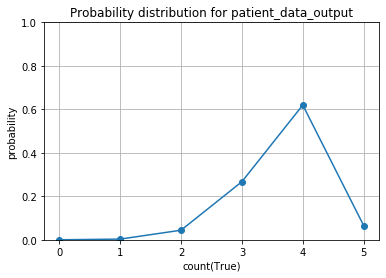

In [6]:
probability_of_count = []
for count in range(N_patient + 1):
    prob = 0
    for i in range(len(count_true_output_list)):
        if count == count_true_output_list[i]:
            prob += probability_list[i]
    probability_of_count.append(prob)
    
plt.plot(np.arange(6), probability_of_count, marker='o')
plt.title('Probability distribution for patient_data_output')
plt.ylim(0, 1)
plt.grid(True)
plt.xlabel('count(True)')
plt.ylabel('probability')
plt.show()

스피너의 밝은 부분이 차지하는 면적의 비율이 90%인 점을 고려한다면 스피너의 바늘이 밝은 부분에서 멈추는 경우가 더 자주 발생할 것이고 이는 질병 유무를 뒤집는 경우가 더 줄어든다는 것을 의미합니다. 이로 인해 데이터 처리 결과에서 질병 보유 환자 수에 대한 확률 분포가 원본 데이터의 질병 보유 환자 수인 4 근방에서 볼록한 모습으로 나타났습니다.

## 5. 정리

환자 질병 유무 데이터가 주어질 때 스피너를 시행하여 발생할 수 있는 모든 경우에 대하여 데이터 처리를 하고 그 결과 질병 보유 환자 수가 어떻게 달라지는지 살펴보았습니다. 그리고 스피너의 밝은 부분이 차지하는 면적의 비율이 50%가 아니라는 점이 결과에 어떤 영향을 미치는지에 대해서도 확률을 계산하여 제시하였습니다.

스피너의 확률이 데이터 처리 결과에 어떻게 영향을 미치는지 안다는 것은 역으로 결과 데이터로부터 원본 데이터의 특성을 유추할 수 있음을 의미합니다.